Attempt 3

Targets: Make model training more robust by using augmented data, and moving Max pool after RF=5

Results:

Parameters: 7,888

Train Acc: 99.29%

Test Acc: 99.46%

Analysis:

Getting better test accuracy after doing above targets

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
if torch.backends.mps.is_available():
    # Apple Silicon GPU
    device = "mps"
    use_cuda = True
elif torch.cuda.is_available():
    # nVidia GPU
    device = "cuda"
    use_cuda = True
else:
    # CPU
    device = "cpu"

In [3]:
# Train Phase transformations
train_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

# Test Phase transformations
test_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [5]:
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if use_cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

In [6]:

from tqdm import tqdm


def train_model(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test_model(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
def plot(train_losses, test_losses, train_acc, test_acc):
    t = [t_items.item() for t_items in train_losses]
    %matplotlib inline
    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(2,2,figsize=(15,10))
    axs[0, 0].plot(t)
    axs[0, 0].set_title("Training Loss")
    axs[1, 0].plot(train_acc)
    axs[1, 0].set_title("Training Accuracy")
    axs[0, 1].plot(test_losses)
    axs[0, 1].set_title("Test Loss")
    axs[1, 1].plot(test_acc)
    axs[1, 1].set_title("Test Accuracy")


In [7]:
from models import Model_3

In [8]:
!pip install torchsummary
from torchsummary import summary

# run summary on cpu first then shift to device
model = Model_3().to("cpu")
summary(model, input_size=(1, 28, 28))


print("Running models on: ", device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 9, 24, 24]             648
              ReLU-6            [-1, 9, 24, 24]               0
       BatchNorm2d-7            [-1, 9, 24, 24]              18
           Dropout-8            [-1, 9, 24, 24]               0
         MaxPool2d-9            [-1, 9, 12, 12]               0
           Conv2d-10           [-1, 10, 10, 10]             810
             ReLU-11           [-1, 10, 10, 10]               0
      BatchNorm2d-12           [-1, 10, 10, 10]              20
          Dropout-13           [-1, 10, 10, 10]               0
           Conv2d-14             [-1, 1

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.07054203003644943 Batch_id=468 Accuracy=91.01: 100%|██████████| 469/469 [00:09<00:00, 49.66it/s] 



Test set: Average loss: 0.0704, Accuracy: 9823/10000 (98.23%)

EPOCH: 1


Loss=0.047248732298612595 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:07<00:00, 60.13it/s]



Test set: Average loss: 0.0409, Accuracy: 9893/10000 (98.93%)

EPOCH: 2


Loss=0.08889728784561157 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:08<00:00, 58.40it/s] 



Test set: Average loss: 0.0339, Accuracy: 9907/10000 (99.07%)

EPOCH: 3


Loss=0.030182883143424988 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:08<00:00, 56.70it/s]



Test set: Average loss: 0.0315, Accuracy: 9913/10000 (99.13%)

EPOCH: 4


Loss=0.00921003706753254 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:08<00:00, 56.75it/s] 



Test set: Average loss: 0.0348, Accuracy: 9887/10000 (98.87%)

EPOCH: 5


Loss=0.006349183153361082 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:08<00:00, 55.44it/s] 



Test set: Average loss: 0.0290, Accuracy: 9912/10000 (99.12%)

EPOCH: 6


Loss=0.0376918651163578 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:08<00:00, 54.55it/s]   



Test set: Average loss: 0.0254, Accuracy: 9923/10000 (99.23%)

EPOCH: 7


Loss=0.004024615976959467 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:08<00:00, 53.28it/s] 



Test set: Average loss: 0.0223, Accuracy: 9931/10000 (99.31%)

EPOCH: 8


Loss=0.06965835392475128 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:08<00:00, 55.69it/s]  



Test set: Average loss: 0.0232, Accuracy: 9930/10000 (99.30%)

EPOCH: 9


Loss=0.02863961271941662 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:08<00:00, 55.27it/s]  



Test set: Average loss: 0.0228, Accuracy: 9934/10000 (99.34%)

EPOCH: 10


Loss=0.024904070422053337 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:08<00:00, 54.42it/s] 



Test set: Average loss: 0.0197, Accuracy: 9937/10000 (99.37%)

EPOCH: 11


Loss=0.006306638475507498 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:08<00:00, 55.41it/s] 



Test set: Average loss: 0.0220, Accuracy: 9932/10000 (99.32%)

EPOCH: 12


Loss=0.017336737364530563 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:08<00:00, 53.70it/s] 



Test set: Average loss: 0.0212, Accuracy: 9943/10000 (99.43%)

EPOCH: 13


Loss=0.0061775450594723225 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:08<00:00, 54.52it/s]



Test set: Average loss: 0.0205, Accuracy: 9946/10000 (99.46%)

EPOCH: 14


Loss=0.015723420307040215 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:08<00:00, 55.16it/s] 



Test set: Average loss: 0.0198, Accuracy: 9941/10000 (99.41%)



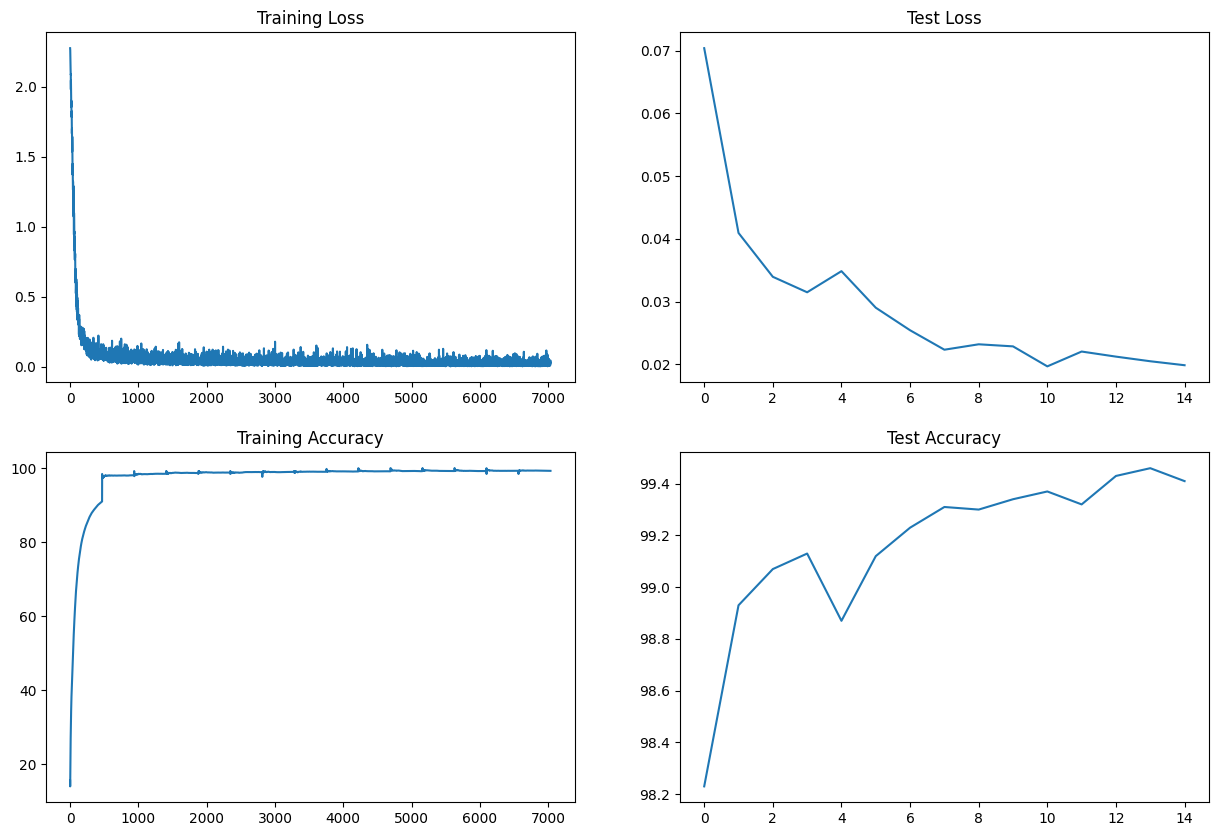

In [9]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []
model =  Model_2().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_model(model, device, train_loader, optimizer, epoch)
    test_model(model, device, test_loader)
plot(train_losses, test_losses, train_acc, test_acc)